## Imports

In [1]:
import os
import glob
import shutil
import numpy as np
import pypianoroll as ppr
import pickle
import pandas as pd

## Separating data

In [2]:
data = pd.read_csv("./data/maestro-v3.0.0/maestro-v3.0.0.csv")

In [3]:
data.head()

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508


In [4]:
maestro_path = "./data/maestro-v3.0.0/"
idx_train = idx_valid = idx_test = 0
destination_director = None

In [6]:
for i in range(len(data)):
    title = data.iloc[i,4]
    split = data.iloc[i,2]
    if split == 'train':
        idx = idx_train
        idx_train += 1
        destination_directory = maestro_path + 'train/'
    elif split == 'validation':
        idx = idx_valid
        idx_valid +=1
        destination_directory = maestro_path + 'validation/'
    else:
        idx = idx_test
        idx_test += 1
        destination_directory = maestro_path + 'test/'

    midi_path = os.path.join(maestro_path, title)
    destination_path = os.path.join(maestro_path, split + str(idx) + '.mid')

    # Open the source MIDI file in binary mode
    with open(midi_path, 'rb') as midi_file:
        midi_content = midi_file.read()

    # Open the destination file in binary mode and write the content
    with open(destination_path, 'wb') as destination_file:
        destination_file.write(midi_content)
    
    os.makedirs(destination_directory, exist_ok=True)

    # Move the MIDI file to the destination directory
    shutil.move(destination_path, destination_directory)
    




## Preprocessing

In [5]:
# Paths to the data
path_train = './data/maestro-v3.0.0/train/*.mid'
path_valid = './data/maestro-v3.0.0/validation/*.mid'
path_test = './data/maestro-v3.0.0/test/*.mid'

path_iter = iter(sorted(glob.glob(path_train)))

In [8]:
!pip install music21

  Obtaining dependency information for music21 from https://files.pythonhosted.org/packages/a1/1b/ef7bdf01df19cc7ac9294531a9c991c6d382bde6bc15c9d106b9a5e547ef/music21-9.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for jsonpickle from https://files.pythonhosted.org/packages/d3/25/6e0a450430b7aa194b0f515f64820fc619314faa289458b7dfca4a026114/jsonpickle-3.0.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 5.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 1.4 MB/s eta 0:00:00


In [9]:
from music21 import converter

def play_midi_file(midi_filename):
    midi_stream = converter.parse(midi_filename)
    midi_stream.show('midi')

./data/maestro-v3.0.0/train/train100.mid


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(31992, 128)


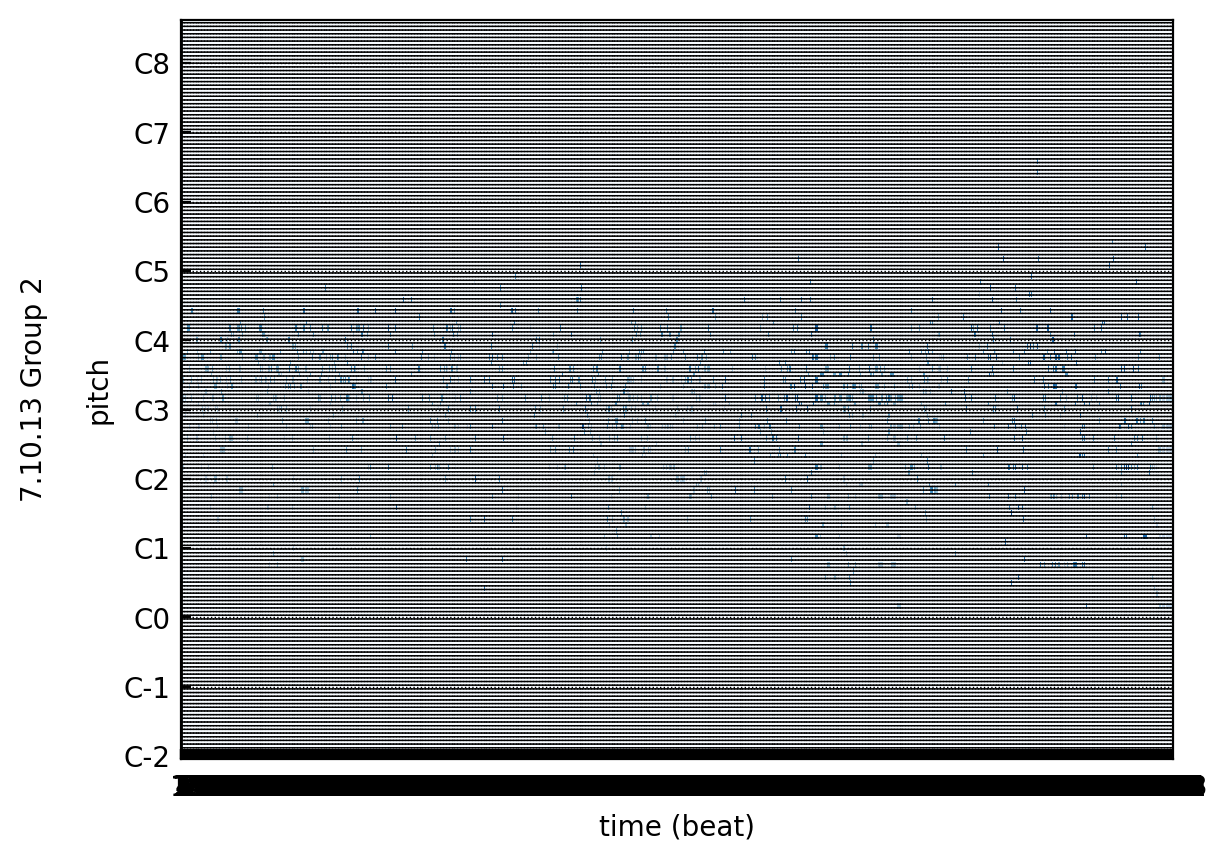

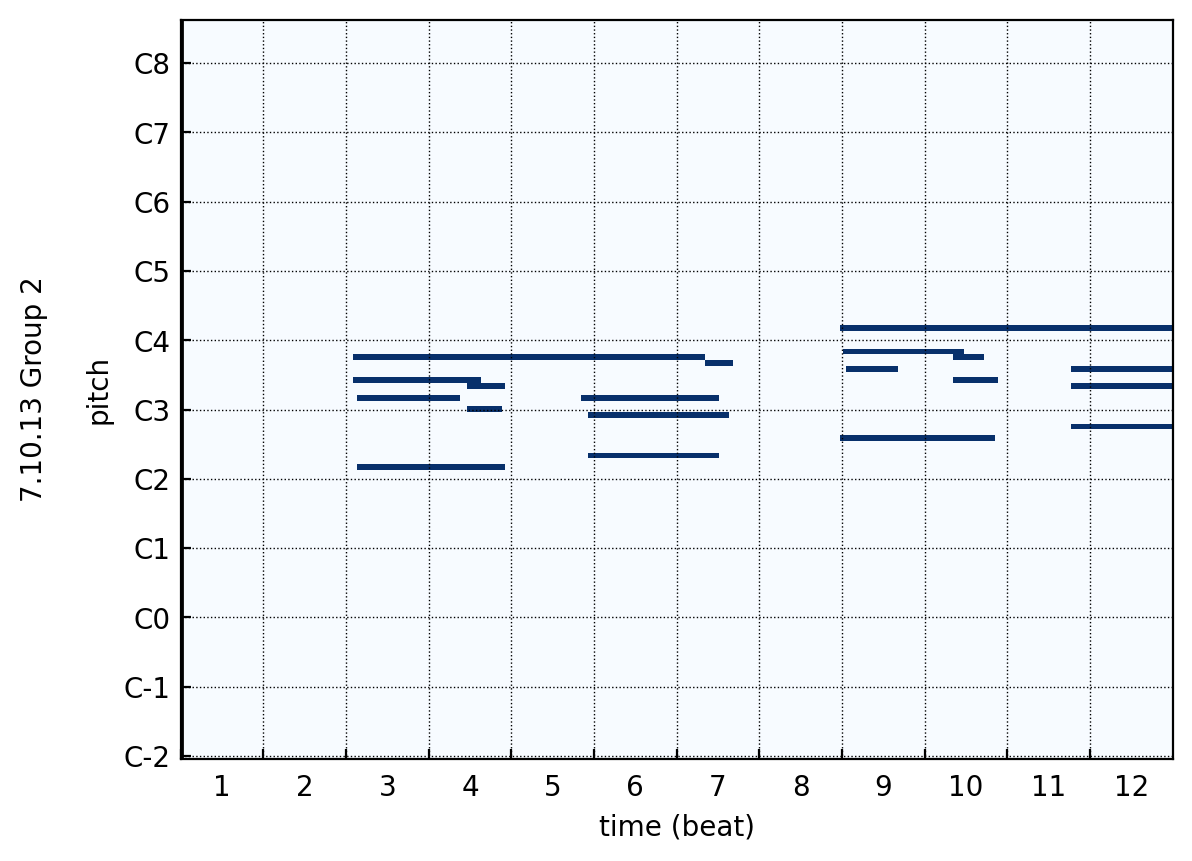

In [10]:
for i in path_iter:
    print(i)
    play_midi_file(i)

    pr = ppr.read(i)
    pr.plot()

    print(pr.tracks[0].pianoroll)
    print(pr.tracks[0].pianoroll.shape)

    pr.trim(0, 12 * pr.resolution)
    pr.binarize()
    pr.plot()

    break


## Function to Extract piano roll from midi

In [7]:
def midi2pr(filename, chunk_size = 128):
    """
    This function receives a filename, reads the associated midi file,
    extracts the piano roll and returns a list of arrays of size (chunk_size,128)
    """
    pr = ppr.read(filename)
    pr = pr.tracks[0].pianoroll # piano roll for the first track

    time = pr.shape[0]
    a =  np.array([pr[i:i+128] for i in range(0, time-chunk_size, chunk_size)])
    return a


In [10]:
path_iter = iter(sorted(glob.glob(path_train)))

train_array = midi2pr(next(path_iter))

for filename in path_iter:
    train_array = np.concatenate((train_array, midi2pr(filename)))

print(train_array.shape)

(214858, 128, 128)


In [11]:
path_iter = iter(sorted(glob.glob(path_valid)))

val_array = midi2pr(next(path_iter))

for filename in path_iter:
    val_array = np.concatenate((val_array, midi2pr(filename)))

print(val_array.shape)

(26227, 128, 128)


In [12]:
path_iter = iter(sorted(glob.glob(path_test)))

test_array = midi2pr(next(path_iter))

for filename in path_iter:
    test_array = np.concatenate((test_array, midi2pr(filename)))

print(test_array.shape)

(26984, 128, 128)


In [13]:
pickle.dump(train_array, open("./data/train_128.pickle", 'wb'))
pickle.dump(val_array, open("./data/valid_128.pickle", 'wb'))
pickle.dump(test_array, open("./data/test_128.pickle", 'wb'))